In [169]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [0]:
test_features = pd.read_csv(io.BytesIO(uploaded['test_features.csv']))

In [0]:
import io
df_train_labels = pd.read_csv(io.BytesIO(uploaded['train_labels.csv']))

In [0]:
import pandas as pd
df_train_features = pd.read_csv(io.BytesIO(uploaded['train_features.csv']))

In [34]:
df_train_features.shape, df_train_labels.shape, df.shape

((59400, 40), (59400, 2), (59400, 41))

In [31]:
df_train_features.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [32]:
df_train_labels.head(2)

,id,status_group
0,69572,functional
1,8776,functional


In [0]:
df = pd.merge(df_train_features, df_train_labels, how='inner', on='id')

In [0]:
df = df.set_index('id')

In [53]:
df.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [55]:
df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [157]:
df.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [58]:
df.describe(include='number')

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
from sklearn.impute import SimpleImputer

def wrangle(df):
  df = df.copy()
  df = df.set_index('id')
  return df

test_features = wrangle(test_features)

In [0]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1)

In [75]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [79]:
y.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [78]:
y_train.value_counts(normalize=True)

functional                 0.544066
non functional             0.383186
functional needs repair    0.072748
Name: status_group, dtype: float64

In [80]:
y_val.value_counts(normalize=True)

functional                 0.540067
non functional             0.386700
functional needs repair    0.073232
Name: status_group, dtype: float64

In [81]:
y_test.value_counts(normalize=True)

functional                 0.538215
non functional             0.390236
functional needs repair    0.071549
Name: status_group, dtype: float64

In [178]:
pd.Series(y_pred).value_counts(normalize=True)

functional        0.699889
non functional    0.300111
dtype: float64

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    DecisionTreeClassifier(max_depth=2, class_weight=None)
)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'mana...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [151]:
pipe.score(X_val, y_val)

0.6848484848484848

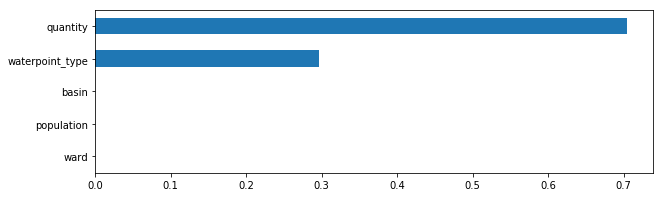

In [152]:
plt.figure(figsize=(10,3))
pd.Series(pipe.named_steps.decisiontreeclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail().plot(kind='barh');

In [162]:
pipe.named_steps.decisiontreeclassifier.n_features_

39

In [168]:
len(test_features.columns)

39

In [0]:
test_features.head()

In [156]:
df.shape

(59400, 40)

In [0]:
y_pred = pipe.predict(test_features)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('decision_tree_baseline.csv', index=False)
files.download('decision_tree_baseline.csv')

In [179]:
len(y_pred)

14358